# Clustering (Assignment 6)

## Student: Rodolfo Lerma

In this assignment, you will implement a K-Means Clustering algorithm from scratch and compare the results to existing sklearn algorithm.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import OrderedDict

## Question 1.1: Write a method that determine Labels from Points and ClusterCentroids, and return a list of a label for each point

In [2]:
def FindLabelOfClosest(Points, ClusterCentroids): # determine Labels from Points and ClusterCentroids
    NumberOfClusters, NumberOfDimensions = ClusterCentroids.shape # dimensions of the initial Centroids
    Distances = np.array([float('inf')]*NumberOfClusters) # centroid distances
    NumberOfPoints, NumberOfDimensions = Points.shape
    Labels = np.array([-1]*NumberOfPoints)
    for PointNumber in range(NumberOfPoints): # assign labels to all data points            
        for ClusterNumber in range(NumberOfClusters): # for each cluster
            # Get distances for each cluster
            Distances[ClusterNumber] = np.linalg.norm(Points.iloc[PointNumber] - ClusterCentroids.iloc[ClusterNumber])                
        Labels[PointNumber] = np.argmin(Distances) # assign to closest cluster
    return Labels # return the a label for each point

## Question 1.2: Write a method that determine centroid of Points with the same label

In [3]:
def CalculateClusterCentroid(Points, Labels): # determine centroid of Points with the same label
    ClusterLabels = np.unique(Labels) # names of labels
    NumberOfPoints, NumberOfDimensions = Points.shape
    ClusterCentroids = pd.DataFrame(np.array([[float('nan')]*NumberOfDimensions]*len(ClusterLabels)))
    for ClusterNumber in ClusterLabels: # for each cluster
        # get mean for each label 
        ClusterCentroids.loc[ClusterNumber, :] = np.mean(Points.loc[ClusterNumber == Labels, :])
    return ClusterCentroids # return the a label for each point

## Question 1.3: Put it all together as such. K-means algorithm partitions the input data into K clusters by iterating between the following two steps:
- Compute the cluster center by computing the arithmetic mean of all the points belonging to the cluster.
- Assign each point to the closest cluster center.

In [4]:
def KMeans(Points, ClusterCentroidGuesses):
    ClusterCentroids = ClusterCentroidGuesses.copy()
    Labels_Previous = None
    # Get starting set of labels
    Labels = FindLabelOfClosest(Points, ClusterCentroids)
    while not np.array_equal(Labels, Labels_Previous):
        # Re-calculate cluster centers based on new set of labels
        ClusterCentroids = CalculateClusterCentroid(Points, Labels)
        Labels_Previous = Labels.copy() # Must make a deep copy
        # Determine new labels based on new cluster centers
        Labels = FindLabelOfClosest(Points, ClusterCentroids)
    return Labels, ClusterCentroids

## Looking at the Data

In [5]:
StoreTxn = pd.read_csv("./Superstore Transaction data.csv")
StoreTxn['Order Date'] = pd.to_datetime(StoreTxn['Order Date'] )

In [6]:
StoreTxn.shape

(9994, 21)

The data frame contain 9994 rows and 21 columns.

In [7]:
StoreTxn.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date                object
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [8]:
StoreTxn.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

No missing data points.

In [9]:
StoreTxn.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


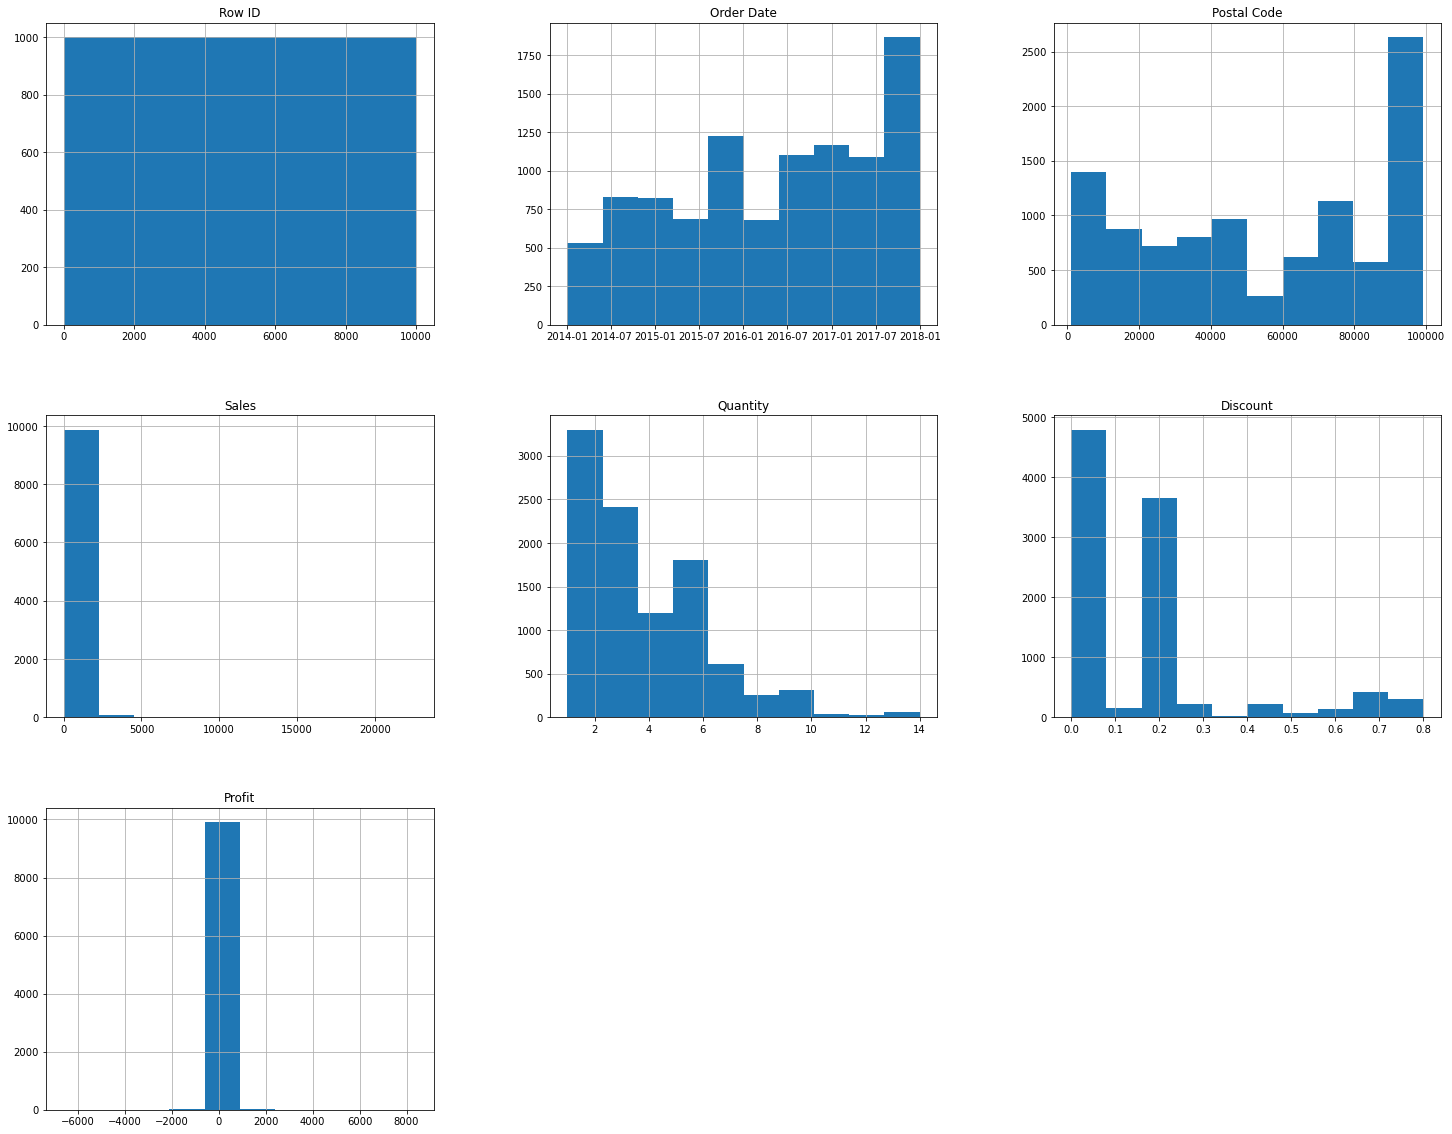

In [10]:
StoreTxn.hist(figsize = (25,20))
plt.show()

In [11]:
categorical_complete = ['Category','Region','Country','Segment','Sub-Category','City','State','Postal Code','Product Name','Product ID','Customer ID','Customer Name','Order ID']
unique_values = []
for i in categorical_complete:
    counts = StoreTxn[i].nunique()
    unique_values.append(counts)
res = {categorical_complete[i]: unique_values[i] for i in range(len(categorical_complete))} 
print(res)

{'Category': 3, 'Region': 4, 'Country': 1, 'Segment': 3, 'Sub-Category': 17, 'City': 531, 'State': 49, 'Postal Code': 631, 'Product Name': 1850, 'Product ID': 1862, 'Customer ID': 793, 'Customer Name': 793, 'Order ID': 5009}


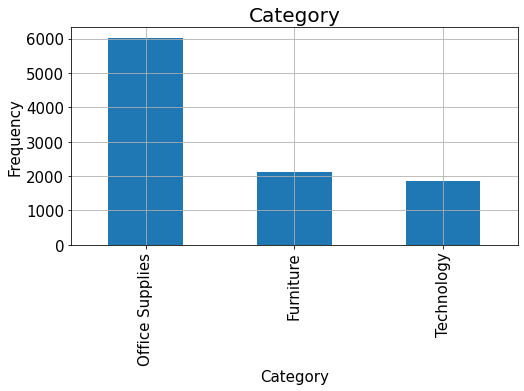

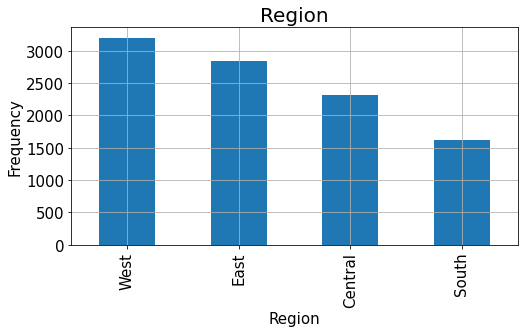

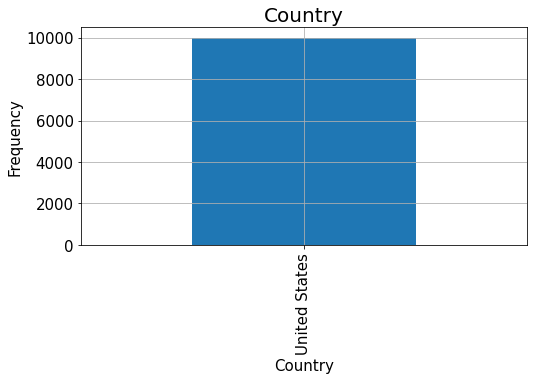

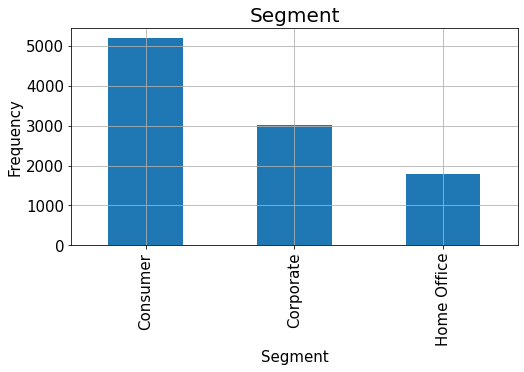

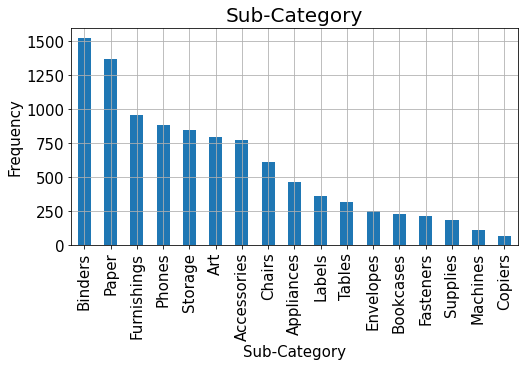

In [12]:
categorical = ['Category','Region','Country','Segment','Sub-Category']
for i in categorical:
    StoreTxn.loc[:,i].value_counts().plot(kind='bar',figsize = (8,4))
    plt.xlabel(i, fontsize = 15)
    plt.ylabel('Frequency',fontsize = 15)
    plt.title(i, fontsize = 20)
    plt.tick_params(axis="x", labelsize=15)
    plt.tick_params(axis="y", labelsize=15)
    plt.grid(True)
    plt.show()

### Time Series (`Sales` & `Profit`)

To see if there is any clear seasonality or event related to the time distribution.

In [13]:
StoreTxn_2 = StoreTxn.copy()
StoreTxn_2.set_index('Order Date', inplace = True)

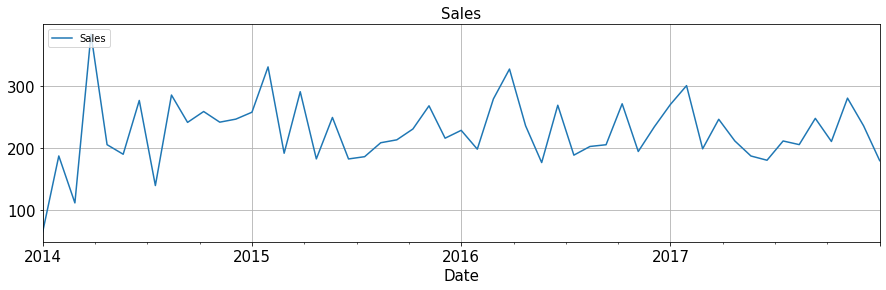

In [14]:
#Time series plot for Price
#To minimize the noise each data point seen here is the mean of a 2 Weeks sample
StoreTxn_2[["Sales"]].resample("4W").mean().plot(figsize=(15,4))
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.xlabel('Date', fontsize = 15)
plt.title('Sales',fontsize=15)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)

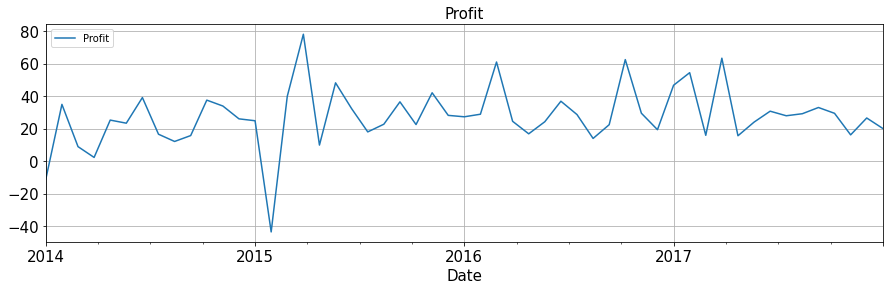

In [15]:
#Time series plot for Price
#To minimize the noise each data point seen here is the mean of a 2 Weeks sample
StoreTxn_2[["Profit"]].resample("4W").mean().plot(figsize=(15,4))
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.xlabel('Date', fontsize = 15)
plt.title('Profit',fontsize=15)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)

In [16]:
StoreTxn.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [17]:
print("Minimal Date=%s, Maximal Date=%s"%(min(StoreTxn["Order Date"]).strftime("%Y-%m-%d"), \
                                          max(StoreTxn["Order Date"]).strftime("%Y-%m-%d")))

Minimal Date=2014-01-03, Maximal Date=2017-12-30


In [18]:
StoreTxn = StoreTxn.sort_values(['Customer ID', 'Order Date'])

## Question 2.1:
- Use groupby to summarize the quantity and dollar columns by user_id and date
- Name the aggregated data txn_agg
- Reset the index for txn_agg to the default and user_id and date to dataframe columns
- Confirm changes

In [19]:
txn_agg = StoreTxn.groupby(['Customer ID','Order Date']).sum() #Summarize quantity and dollar by user_id - date.  
txn_agg = txn_agg[['Sales','Quantity']]
txn_agg.reset_index(inplace = True)
txn_agg = txn_agg.sort_values(['Customer ID', 'Order Date'])

In [20]:
txn_agg.head(10)

,Customer ID,Order Date,Sales,Quantity
0,AA-10315,2014-03-31,726.548,4
1,AA-10315,2014-09-15,29.500,5
2,AA-10315,2015-10-04,26.960,2
3,AA-10315,2016-03-03,4406.072,14
4,AA-10315,2017-06-29,374.480,5
5,AA-10375,2014-04-21,16.520,5
6,AA-10375,2014-10-24,34.272,3
7,AA-10375,2015-02-03,178.370,5
8,AA-10375,2015-05-08,5.248,2
9,AA-10375,2015-11-13,84.960,6


## Question 2.2:Using the aggregated data, obtain recency, frequency and monetary features for both dollar and quantity. Use a 7-day moving window for frequency and monetary. Call your new features last_visit_ndays (recency) quantity_roll_sum_7D (frequency) and dollar_roll_sum_7D (monetary)

Extract RFM features from the transaction data:
- Recency: when was the last purchase they made
- Frequency: how often do they make a purchase in the last month (or any given window you choose)
- Monetary: how much money did they spend in the last month

In [21]:
Start_Date_Obj = dt.datetime.strptime("2/1/2014", "%m/%d/%Y")
End_Date_Obj = dt.datetime.strptime("11/1/2017", "%m/%d/%Y")
Time_Window = 60 #days. Only consider customers who have activities within the recent 60 days
FM_Window = 7 #days for frequency and monetary

check_point_date = Start_Date_Obj

#Empty Lists
UserID = []
Checkpoint = []
Recency = []
Frequency = []
Monetary_Value = []
Monetary_Quantity = []

while check_point_date <= End_Date_Obj:
    window_start = check_point_date - dt.timedelta(days = Time_Window)
    mask = (StoreTxn["Order Date"] >= window_start) & (StoreTxn["Order Date"] < check_point_date)
    
    # Get the data in [checkpoint-60days, checkpoint]
    data_checkpoint = StoreTxn.loc[mask]
    
    # Get the ids of users who have activities in [checkpoint-60days, checkpoint]
    unique_users = list(set(data_checkpoint["Customer ID"]))
    
    FM_Window_Start = check_point_date - dt.timedelta(days = FM_Window)
    
    for user in unique_users:
        UserID.append(user) #Append each individual user to the list
        Checkpoint.append(check_point_date)
        
        mask = data_checkpoint["Customer ID"] == user
        data_checkpoint_user = data_checkpoint.loc[mask]
        delta = check_point_date - max(data_checkpoint_user["Order Date"])
        recency = delta.days #Recency, days between checkpoint and last transaction time
        
        mask = data_checkpoint_user["Order Date"] >= FM_Window_Start
        data_checkpoint_user_fm = data_checkpoint_user.loc[mask]
        frequency = data_checkpoint_user_fm.shape[0]
        value = np.sum(data_checkpoint_user_fm.iloc[:, 17]) #monetary values
        quantity = np.sum(data_checkpoint_user_fm.iloc[:, 18])#monetary quantity
        
        #Append values
        Recency.append(recency)
        Frequency.append(frequency)
        Monetary_Value.append(value)
        Monetary_Quantity.append(quantity)
        
    check_point_date = check_point_date + dt.timedelta(days = 1)

## Question 2.3: Combine all three features into a single DataFrame and call it txn_roll

In [22]:
RFM_Dict = OrderedDict([ ('UserID', UserID),
          ('Checkpoint', Checkpoint),
          ('Last_visit_ndays', Recency),
          ('Frequency', Frequency),
          ('Sales_roll_sum_7D', Monetary_Value),
          ('Quantity_roll_sum_7D', Monetary_Quantity)])

txn_roll = pd.DataFrame.from_dict(RFM_Dict)

## Question 2.4: Use fillna to replace missing values for recency with a large value like 100 days (whatever makes business sense). HINT: You can use pd.Timedelta('100 days') to set the value.

In [23]:
txn_roll.head(2)

,UserID,Checkpoint,Last_visit_ndays,Frequency,Sales_roll_sum_7D,Quantity_roll_sum_7D
0,JC-15340,2014-02-01,4,1,3.928,1
1,ME-17320,2014-02-01,26,0,0.000,0


In [24]:
txn_roll.isnull().sum()

UserID                  0
Checkpoint              0
Last_visit_ndays        0
Frequency               0
Sales_roll_sum_7D       0
Quantity_roll_sum_7D    0
dtype: int64

## Question 2.5: Merge the aggregated data churn_agg with the RFM features in churn_roll. You can use the merge method to do this with the right keys specified.

In [25]:
txn_rfm = txn_roll[['Last_visit_ndays', 'Frequency', 'Sales_roll_sum_7D', 'Quantity_roll_sum_7D']]

In [26]:
txn_rfm.describe()

,Last_visit_ndays,Frequency,Sales_roll_sum_7D,Quantity_roll_sum_7D
count,229855.000000,229855.000000,229855.000000,229855.000000
mean,28.878280,0.273272,63.274312,1.033713
std,17.262102,0.873741,392.762124,3.502613
min,1.000000,0.000000,0.000000,0.000000
25%,14.000000,0.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000,0.000000
75%,44.000000,0.000000,0.000000,0.000000
max,60.000000,14.000000,23661.228000,55.000000


In [27]:
from sklearn.preprocessing import StandardScaler# Initialize the Object

#Normalize values
scaler = StandardScaler()# Fit and Transform The Data
scaler.fit(txn_rfm)
normalization = scaler.transform(txn_rfm)

#columns_norm = ['Recency_norm', 'Frequency_norm', 'Sales_norm', 'Quantity_norm']

txn_rfm_norm = pd.DataFrame(normalization)

## Question 3.1: Train the k-means algorithm you developed earlier on the RFM features using  𝑘=4 . What are the cluster centroids? The cluster centroids should be reported in the original scale, not the standardized scale.

In [28]:
ClusterCentroidGuesses = pd.DataFrame()
ClusterCentroidGuesses.loc[:,0] = [1, 20, 40, 60]
ClusterCentroidGuesses.loc[:,1] = [0, 6, 10, 14]
ClusterCentroidGuesses.loc[:,2] = [0, 2000, 10000, 20000]

In [29]:
#Normalize values
scaler2 = StandardScaler()# Fit and Transform The Data
scaler2.fit(ClusterCentroidGuesses)
guesses = scaler2.transform(ClusterCentroidGuesses)

#columns_norm = ['Recency_Guess','Frequency_Guess','Value_Guess']

ClusterCentroidGuesses_norm = pd.DataFrame(guesses)

In [30]:
# txn_rfm_norm = txn_rfm_norm.rename(columns = {'Recency_norm':0,'Frequency_norm': 1,'Value_norm':2})

In [31]:
y = txn_rfm_norm[[0,1]]

In [32]:
x = ClusterCentroidGuesses_norm[[0,1]]

In [33]:
y

,0,1
0,-1.441211,0.831744
1,-0.166740,-0.312762
2,-0.919837,-0.312762
3,-0.861906,-0.312762
4,-0.746045,-0.312762
...,...,...
229850,1.397383,-0.312762
229851,1.802897,-0.312762
229852,0.644287,-0.312762
229853,0.064982,-0.312762


In [34]:
x

,0,1
0,-1.327917,-1.450105
1,-0.465339,-0.290021
2,0.442639,0.483368
3,1.350617,1.256757


In [35]:
ClusterCentroidGuesses = pd.DataFrame()
ClusterCentroidGuesses.loc[:,0] = [-1, 2, 0, -2]
ClusterCentroidGuesses.loc[:,1] = [2, -2, 0, 1]

In [36]:
ClusterCentroidGuesses

,0,1
0,-1,2
1,2,-2
2,0,0
3,-2,1


In [37]:
Labels_2, ClusterCentroids_2 = KMeans(y, ClusterCentroidGuesses)

In [39]:
ClusterCentroids_2

,0,1
0,-1.444623,4.298400
1,1.029440,-0.312762
2,-0.502257,-0.312762
3,-1.441736,1.208971


In [40]:
Labels_2

array([3, 2, 2, ..., 1, 2, 1])

## Question 3.2: Pick few pairs and plot scatter plots along with cluster centroids.

In [41]:
def Plot2DKMeans(Points, Labels, ClusterCentroids, Title):
    for LabelNumber in range(max(Labels)+1):
        LabelFlag = Labels == LabelNumber
        color =  ['c', 'm', 'y', 'b', 'g', 'r', 'c', 'm', 'y', 'b', 'g', 'r', 'c', 'm', 'y'][LabelNumber]
        marker = ['s', 'o', 'v', '^', '<', '>', '8', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'][LabelNumber]
        plt.scatter(Points.loc[LabelFlag,0], Points.loc[LabelFlag,1],
                    s= 100, c=color, edgecolors="black", alpha=0.3, marker=marker)
        plt.scatter(ClusterCentroids.loc[LabelNumber,0], ClusterCentroids.loc[LabelNumber,1], s=200, c="black", marker=marker)
    plt.title(Title)
    plt.grid()
    plt.show()

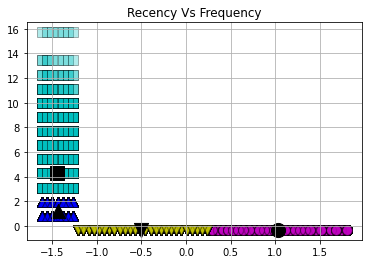

In [42]:
Title = 'Recency Vs Frequency'
Plot2DKMeans(txn_rfm_norm[[0,1]], Labels_2, ClusterCentroids_2, Title)

In [ ]:
# Title = 'Frequency Vs Value'
# Plot2DKMeans(Points, Labels, ClusterCentroids, Title)

## [Bonus] Question 4: Train k-means model using sklearn library and compare results to the model developed above.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [ ]:
variables = ['Last_visit_ndays','Frequency','Sales_roll_sum_7D','Quantity_roll_sum_7D']

In [ ]:
# Import library
from sklearn.preprocessing import StandardScaler# Initialize the Object
scaler = StandardScaler()# Fit and Transform The Data

scaler.fit(txn_roll[variables])
RFM_norm = scaler.transform(txn_roll[variables])

columns_norm = ['Recency_Norm','Frequency_Norm','Value_Norm','Quantity_Norm']

df = pd.DataFrame(RFM_norm, columns = columns_norm)

final_df = pd.concat([txn_roll,df], axis = 1)

In [ ]:
final_df.head()

### Choosing K 

In [ ]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_df[columns_norm])
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroidplt.title('The Elbow Method')

plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.grid()
plt.show()

From the plot above it decided to choose a **K=4** since from that moment forward it seems the decrement in SSE goes to linear and not much benefit is obtained by increasing the complexiting.

### KMeans

In [ ]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(final_df[columns_norm])

final_df["Cluster"] = model.labels_

In [ ]:
final_df.groupby('Cluster').agg({
    'Last_visit_ndays':'mean',
    'Frequency':'mean',
    'Sales_roll_sum_7D':'mean'}).round(2)

In [ ]:
# Melt The Data
df_nor_melt = pd.melt(final_df.reset_index(),
                      id_vars=['UserID', 'Cluster'],
                      value_vars=['Recency_Norm','Frequency_Norm','Value_Norm'],
                      var_name='Attribute',
                      value_name='Value')

### Looking at Results

In [ ]:
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

In [ ]:
df = final_df
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Frequency_Norm[df.Cluster == 0], df["Value_Norm"][df.Cluster == 0], df["Recency_Norm"][df.Cluster == 0], c='blue', s=60)
ax.scatter(df.Frequency_Norm[df.Cluster == 1], df["Value_Norm"][df.Cluster == 1], df["Recency_Norm"][df.Cluster == 1], c='red', s=60)
ax.scatter(df.Frequency_Norm[df.Cluster == 2], df["Value_Norm"][df.Cluster == 2], df["Recency_Norm"][df.Cluster == 2], c='green', s=60)
ax.scatter(df.Frequency_Norm[df.Cluster == 3], df["Value_Norm"][df.Cluster == 3], df["Recency_Norm"][df.Cluster == 3], c='purple', s=60)
ax.view_init(30, 185)
plt.xlabel("Frequency_Norm")
plt.ylabel("Value_Norm")
ax.set_zlabel('Recency_Norm')
plt.show()

## Question 5: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: 

During this Assignment there were some details that are part of K-Means that I did not fully notice until this time working on the algorithm from scratch. One of the details is the resources are needed to run this model, since we are checking every single row (data point) against each of the K clusters (centroids of each cluster) and this multiple times until at least a local minimum is found. If on top of this we look for the best k number of clusters by doing cross validation, then the resources needed grow exponentially. 


On working on this assignment, it was self-evident the immense value that unsupervised learning has in the industry, by helping on exploring and characterizing data in a better way and providing some guidance on where to pay attention to maximize a particular result.

#### Notes From The Analysis:

- From the data and based on the SSE curve it was decided to use a **K = 4** as it seems to be the best value to provide a better SSE and lower complexity.


- From the analysis it was possible to identify 4 probable distinct groups of customers.
    - (0) Low Freq, Low Recency, Low Value
    - (1) High Freq, Low Recency, Medium Value
    - (2) Low Freq, Medium Recency, Low Value
    - (3) High Freq, Low Recency, Hight Value
    
    

- From the results above the recommendation would be to send promotions to the Cluster (1) as it seems those customers would be the easiest to convert to active users buying products.


- Customers in Cluster (3) are the most engaged with the product and if needed a small incentive might help to keep them that way.


- Customers in Clusters (2) & (0) are not engaging at all, and it would be potentially the most expensive groups to bring back as an active customer (group 2 being the least engaged).
